<a href="https://colab.research.google.com/github/JacksonKerr/LinearRegression/blob/main/PCA_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFO204 Assignment 2
---
*Jackson Kerr | 2942576*

[GitHub Repo](https://github.com/JacksonKerr/LinearRegression)

---



#### Doc Options:

In [ ]:
fast = True  # If true, uses stored graph images from GitHub repo for speed

## Helper functions from labs

In [ ]:
def extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC'):
    """
       take a PCA model and extract its loadings into a data frame for easier interrogation
    """
    if pipeline_component is not None:
        pca = pca[pipeline_component]
        
    X = pca.components_.T
    
    return pd.DataFrame(X, columns=[ f'{prefix}{i+1}' for i in range(X.shape[1]) ], index=feature_names)

In [ ]:
def biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None):
    """
      plot two principal components of data embedded via PCA along with their feature loadings
    """
    xs = X[:, pc1]
    ys = X[:, pc2]
    
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())    
    sns.scatterplot(x=xs*scalex, y=ys*scaley, hue=y, palette='viridis')
    
    if loadings is not None:
        n = len(loadings)
        if labels is None:
            labels = loadings.index.values
        for i in range(n):
            plt.arrow(0, 0, loadings.iloc[i, pc1], loadings.iloc[i, pc2], color='#ce2227', width=0.01, head_width=0.04)
            plt.text(loadings.iloc[i, pc1]* 1.15, loadings.iloc[i, pc2] * 1.15, labels[i], color='#ce2227', ha='center', va='center')
        
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    plt.grid()

In [ ]:
def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    """
        produce a plot from a PCA embedding that visualises the amount of 
        explained variance for each of the principal components 
    """
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()

##Gettin That Data:
Let's start by importing the wine data.

In [ ]:
from sklearn.datasets import load_wine
import pandas as pd

wine_data = load_wine()

# Features
wine_x = pd.DataFrame(wine_data['data'], columns=wine_data['feature_names'])

# Target
wine_y = wine_data['target']

# Dataset with target
wine = wine_x.copy()
wine['target'] = wine_y;

## Exploratory Data Analysis

#### Description:
Let's have a high level look at the data.

In [ ]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

13 features plus the target. All inputs are decimal 64 bit floats. No null values.

In [ ]:
classes = list(set(wine['target']))
classes

[0, 1, 2]

The target only contains 3 unique values. This is likely an encoding for a three classes.

In [ ]:
wine['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

Slight imbalance in occurances of each class, may need to take this into acocunt when modeling.

In [ ]:
wine_x.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


There are large differences between the standard deviations of some features. Standardisation is likely to be useful when doing PCA.

Let's look at the relationships between the variables using hue="target".

In [ ]:
import seaborn as sns
import numpy as np

if fast: 
   # Get stored pairplot from GitHub repo
  from IPython.display import Image
  from IPython.core.display import HTML 
  img = Image(url= "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/resources/wine_data_pairplot.png")
else: img = sns.pairplot(wine, hue='target')
img


### Upon Examination:
# TODO EXAMINE

## PCA

In [ ]:
print(len(wine_x))
display(wine_x.head())

178


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


<Figure size 360x360 with 0 Axes>

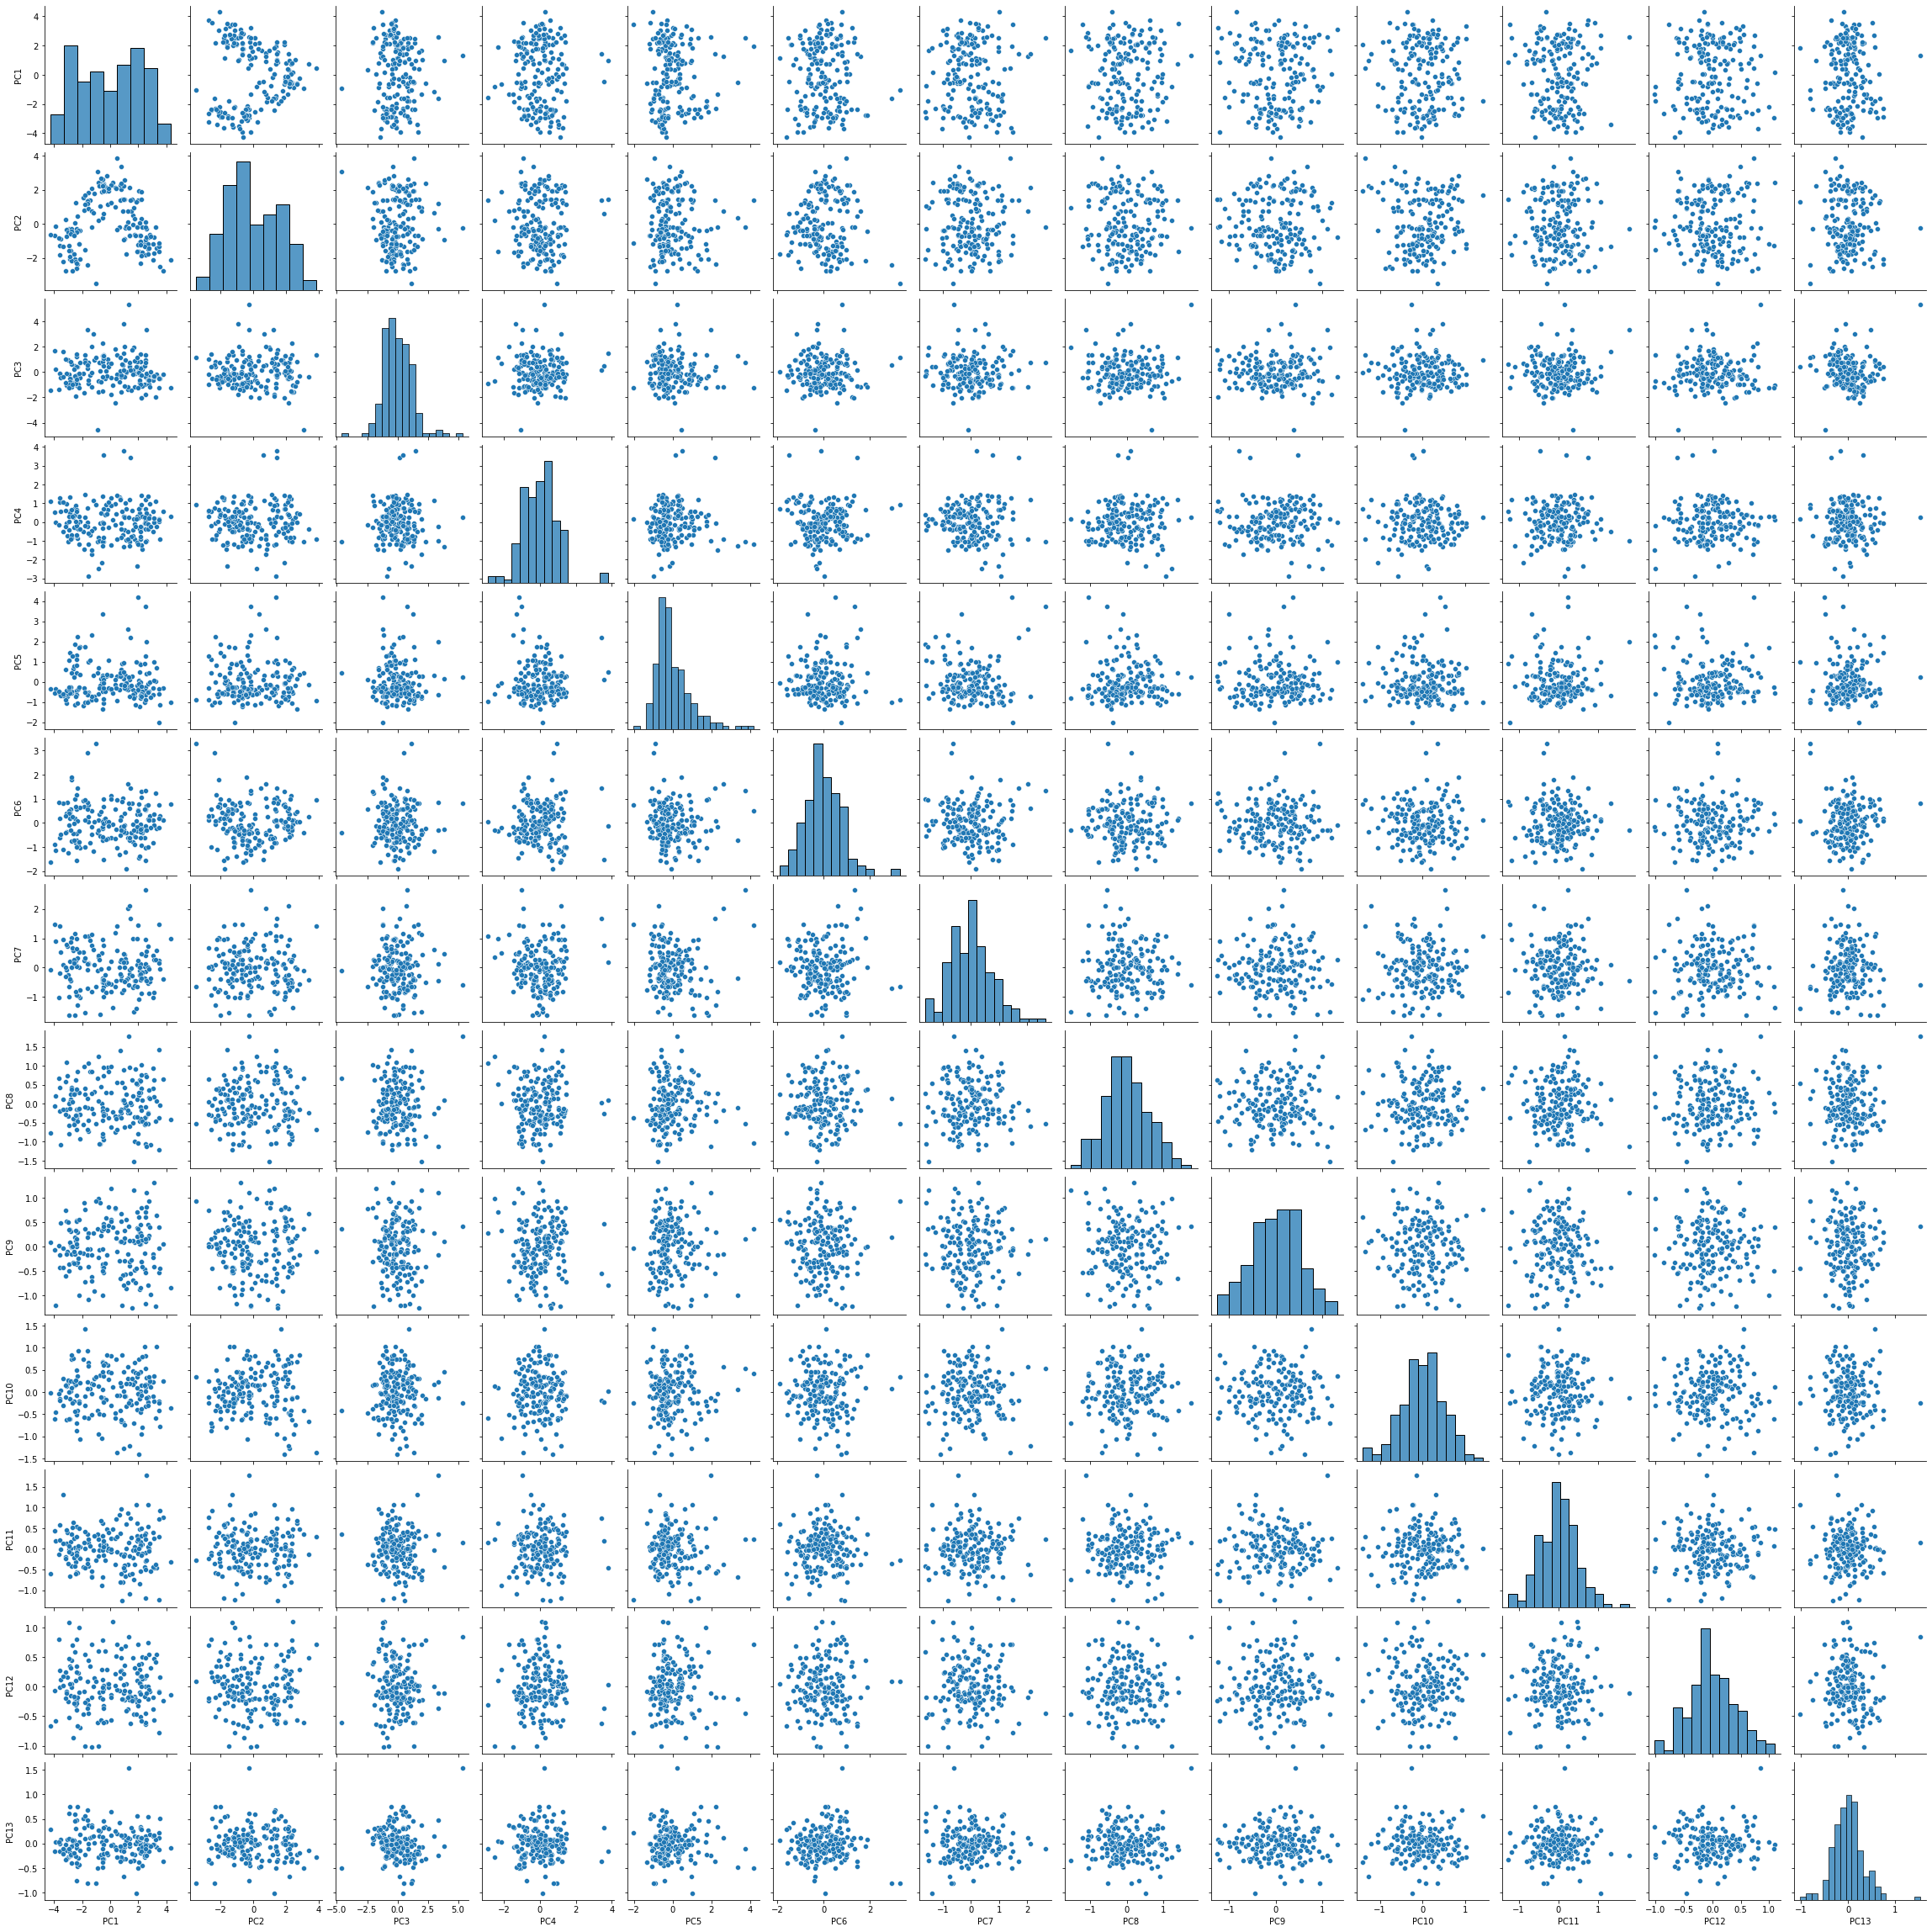

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcohol,0.144329,-0.483652,-0.207383,-0.017856,-0.265664,-0.213539,-0.056396,-0.396139,0.508619,0.211605,-0.225917,-0.266286,0.014970
malic_acid,-0.245188,-0.224931,0.089013,0.536890,0.035214,-0.536814,0.420524,-0.065827,-0.075283,-0.309080,0.076486,0.121696,0.025964
ash,-0.002051,-0.316069,0.626224,-0.214176,-0.143025,-0.154475,-0.149171,0.170260,-0.307694,-0.027125,-0.498691,-0.049622,-0.141218
alcalinity_of_ash,-0.239320,0.010591,0.612080,0.060859,0.066103,0.100825,-0.286969,-0.427970,0.200449,0.052799,0.479314,-0.055743,0.091683
magnesium,0.141992,-0.299634,0.130757,-0.351797,0.727049,-0.038144,0.322883,0.156361,0.271403,0.067870,0.071289,0.062220,0.056774
total_phenols,0.394661,-0.065040,0.146179,0.198068,-0.149318,0.084122,-0.027925,0.405934,0.286035,-0.320131,0.304341,-0.303882,-0.463908
flavanoids,0.422934,0.003360,0.150682,0.152295,-0.109026,0.018920,-0.060685,0.187245,0.049578,-0.163151,-0.025694,-0.042899,0.832257
nonflavanoid_phenols,-0.298533,-0.028779,0.170368,-0.203301,-0.500703,0.258594,0.595447,0.233285,0.195501,0.215535,0.116896,0.042352,0.114040
proanthocyanins,0.313429,-0.039302,0.149454,0.399057,0.136860,0.533795,0.372139,-0.368227,-0.209145,0.134184,-0.237363,-0.095553,-0.116917
color_intensity,-0.088617,-0.529996,-0.137306,0.065926,-0.076437,0.418644,-0.227712,0.033797,0.056218,-0.290775,0.031839,0.604222,-0.011993


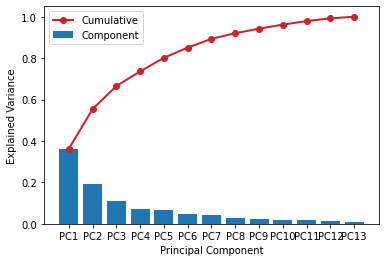

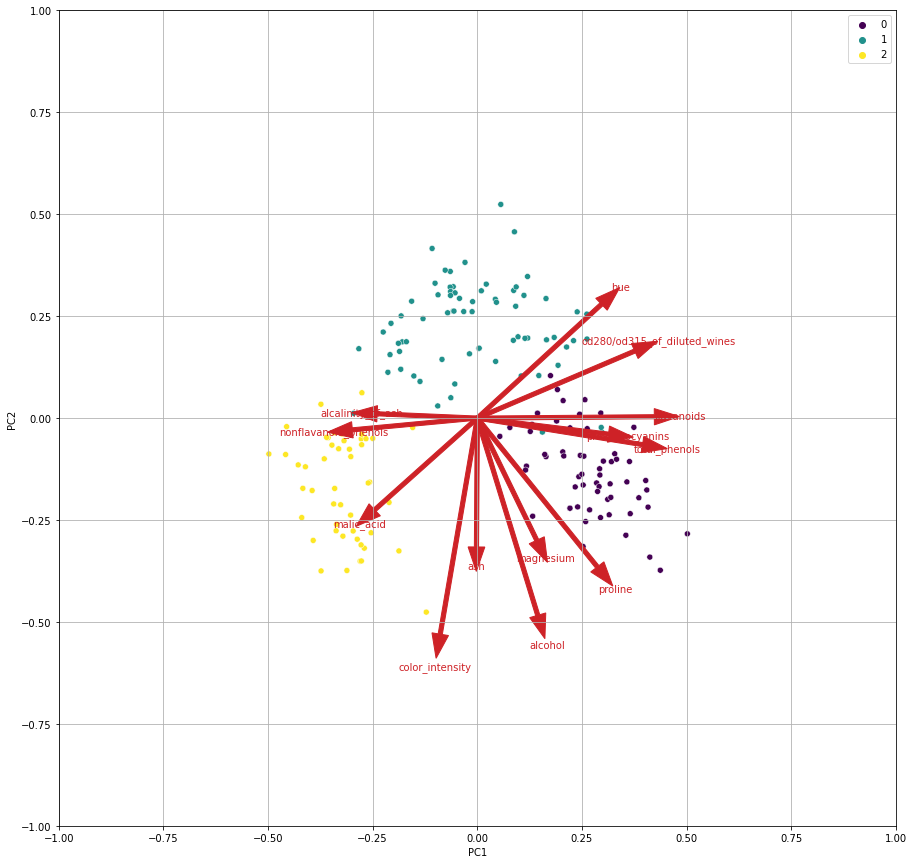

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline

pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
P = pipe.fit_transform(wine_x)
fig = plt.figure(figsize=(5, 5))
sns.pairplot(pd.DataFrame(P, columns=[ f'PC{i+1}' for i in range(len(wine_data['feature_names'])) ]));
plt.show()
display(extract_loadings(pca, feature_names=wine_data['feature_names']))
screeplot(pca)
fig = plt.figure(figsize=(15, 15))
biplot(P, extract_loadings(pca, feature_names=wine_data['feature_names']), y=wine_y)
plt.show()

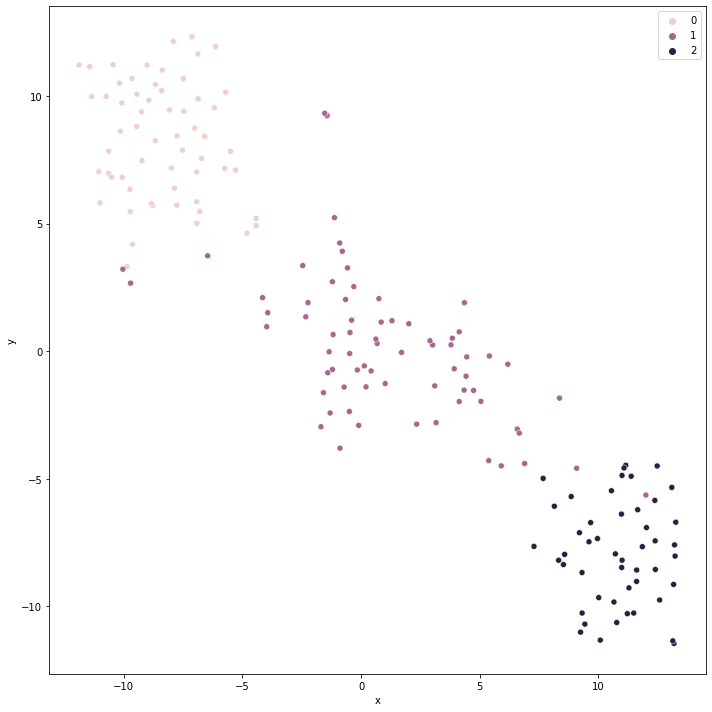

In [ ]:
# TODO, THIS IS ONLY COPY-PASTED FORM THE LAB WORK

from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

pca = PCA(n_components=7)
tsne = TSNE()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('tsne', tsne)])
P = pipe.fit_transform(wine_x)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=P[:, 0], y=P[:, 1], hue=wine_y, hue_order=[ f'{i}' for i in range(10) ])
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()